In [1]:
import torch

In [2]:
import os
import sys
# import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix, fn_plot_torch_hist

In [3]:
print(fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
RANDOM_STATE = 0 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 30 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [6]:
train_df = pd.read_csv(r'C:\Users\Administrator.DAI-PC2\Desktop\DNN\Day7\fashion-mnist_train.csv')
test_df = pd.read_csv(r"C:\Users\Administrator.DAI-PC2\Desktop\DNN\Day7\fashion-mnist_test.csv")

test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
class_labels = {
          0 : 'T-shirt/top',
          1 : 'Trouser',
          2 : 'Pullover',
          3 : 'Dress',
          4 : 'Coat',
          5 : 'Sandal',
          6 : 'Shirt',
          7 : 'Sneaker',
          8 : 'Bag',
          9 : 'Ankle boot'
          }

In [8]:
class FashionDS(Dataset):


  def __init__ (self,
                dataframe: pd.DataFrame,
                device : str = device
                ):
    self.df = dataframe
    self.device = device

    self.labels = self.df['label'].to_numpy()
    X = self.df.drop('label', axis=1).to_numpy()

    self.features = X/255.

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    #extract features and label from the dataframe row
    features = self.features[index]
    label = self.labels[index]

    #convert to pytorch tensors
    features = torch.tensor(features,
                            dtype=torch.float32,
                            device=self.device)
    label = torch.tensor(label,
                         dtype=torch.int64,
                         device=self.device)

    return features, label


In [9]:
train_ds = FashionDS(train_df)

test_ds = FashionDS(test_df)

In [10]:
train_ds

In [11]:
train_loader = DataLoader(train_ds,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(test_ds,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

In [12]:
train_loader

torch.Size([32, 784])
tensor(1.)


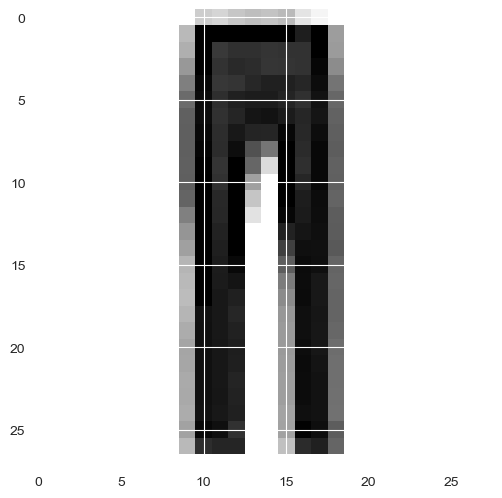

In [13]:
images, targets = next(iter(train_loader))
print(images.shape)
print(images[0].max())


images = images.cpu().numpy()
plt.imshow(images[0].reshape(28, 28), cmap = plt.cm.binary)

In [14]:
images, targets = next(iter(train_loader))

images = images.cpu().numpy()  # to convert from cuda to numpy for displaying the images
targets = targets.cpu().numpy()
targets

array([9, 2, 3, 8, 2, 2, 6, 7, 6, 3, 8, 5, 8, 0, 9, 9, 9, 4, 6, 3, 4, 8,
       1, 6, 8, 8, 7, 0, 9, 0, 1, 7], dtype=int64)

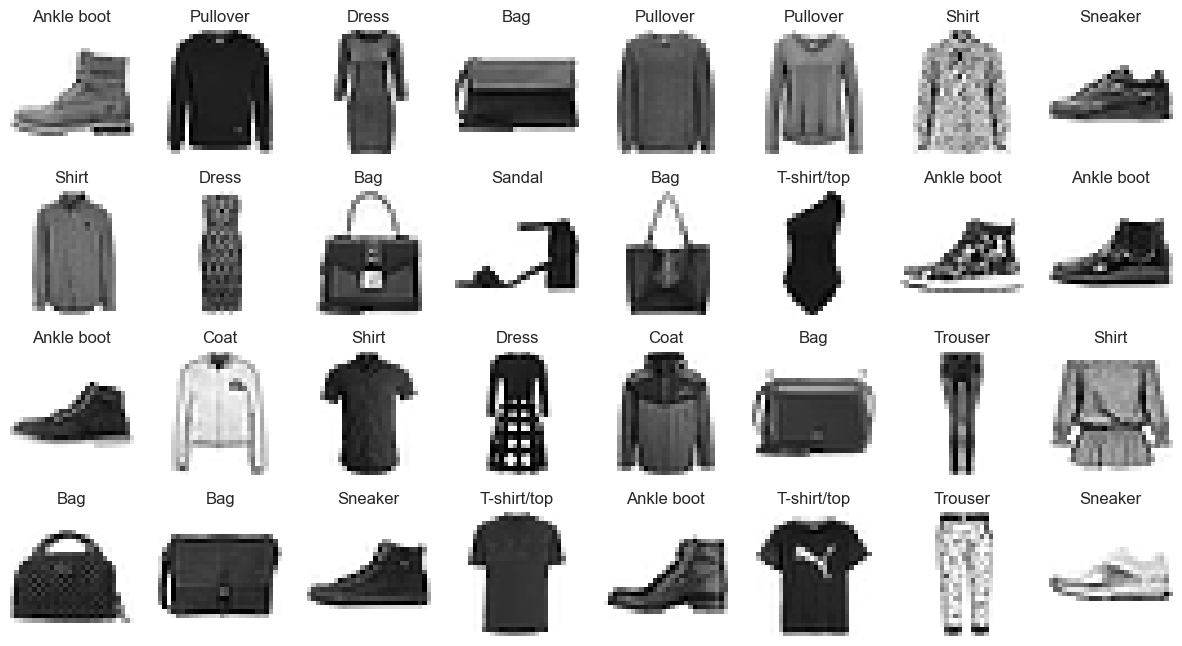

In [15]:
plt.figure(figsize = (15, 8))

for i in range(BATCH_SIZE) :
  plt.subplot(4, 8, i+1)
  plt.imshow(images[i].reshape(28, 28), cmap = plt.cm.binary) # cmap = to make colour black and white
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(class_labels[targets[i]])

In [16]:
128/32

4.0

In [17]:
input_shape = train_df.shape[1] -1
input_shape

784

In [18]:
class Model(nn.Module):

    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,128) #784 x 128 /6
        self.activ1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 32)  # 128 x 32 / 4
        self.activ2 = nn.ReLU()
        self.layer3 = nn.Linear(32, 10) # 32 x 10 / 3
        self.softmax = nn.LogSoftmax(dim = 1) # 32 x 10 / 3

    def forward(self, x):
        x = self.layer1(x)  #forward pass in layer1
        x = self.activ1(x)
        x = self.layer2(x)  #forward pass in layer2
        x = self.activ2(x)
        x = self.layer3(x)  #forward pass in layer3
        return self.softmax(x)

net = Model(input_dim = input_shape).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (activ2): ReLU()
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [19]:
loss_fn = nn.CrossEntropyLoss()

In [20]:
images, labels = next(iter(train_loader))


images.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

In [21]:
outputs = net(images)

preds = torch.argmax(outputs, dim = 1)

batch_loss = loss_fn(outputs, labels)

batch_loss

tensor(2.3208, grad_fn=<NllLossBackward0>)

In [22]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):

    # Training loop
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(train_loader):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)

        preds = torch.argmax(outputs, dim = 1)

        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

        batch_loss.backward()

        optimizer.step()

        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)

    train_loss /= len(train_ds)
    train_acc /= len(train_ds)

    loss.append(train_loss)
    acc.append(train_acc)

    # Testing loop
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():

        for data in test_loader:

            inputs, labels = data

            outputs = net(inputs)

            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, labels)
            #print(batch_loss)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)

        test_loss /= len(test_ds)
        test_acc /= len(test_ds)

        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:0.5360, test:0.4388 | Acc - train:0.8086, test:0.8386
At epoch 5 | Loss - train:0.2927, test:0.3371 | Acc - train:0.8912, test:0.8750
At epoch 10 | Loss - train:0.2423, test:0.3156 | Acc - train:0.9088, test:0.8856
At epoch 15 | Loss - train:0.2097, test:0.3444 | Acc - train:0.9217, test:0.8935
At epoch 20 | Loss - train:0.1827, test:0.3169 | Acc - train:0.9318, test:0.8994
At epoch 25 | Loss - train:0.1660, test:0.3532 | Acc - train:0.9376, test:0.8980


In [23]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.535988,0.438777,0.808650,0.8386
1,1,0.388149,0.371057,0.859067,0.8624
2,2,0.350682,0.339433,0.872900,0.8766
3,3,0.325688,0.338570,0.880950,0.8759
4,4,0.308388,0.325102,0.886967,0.8825


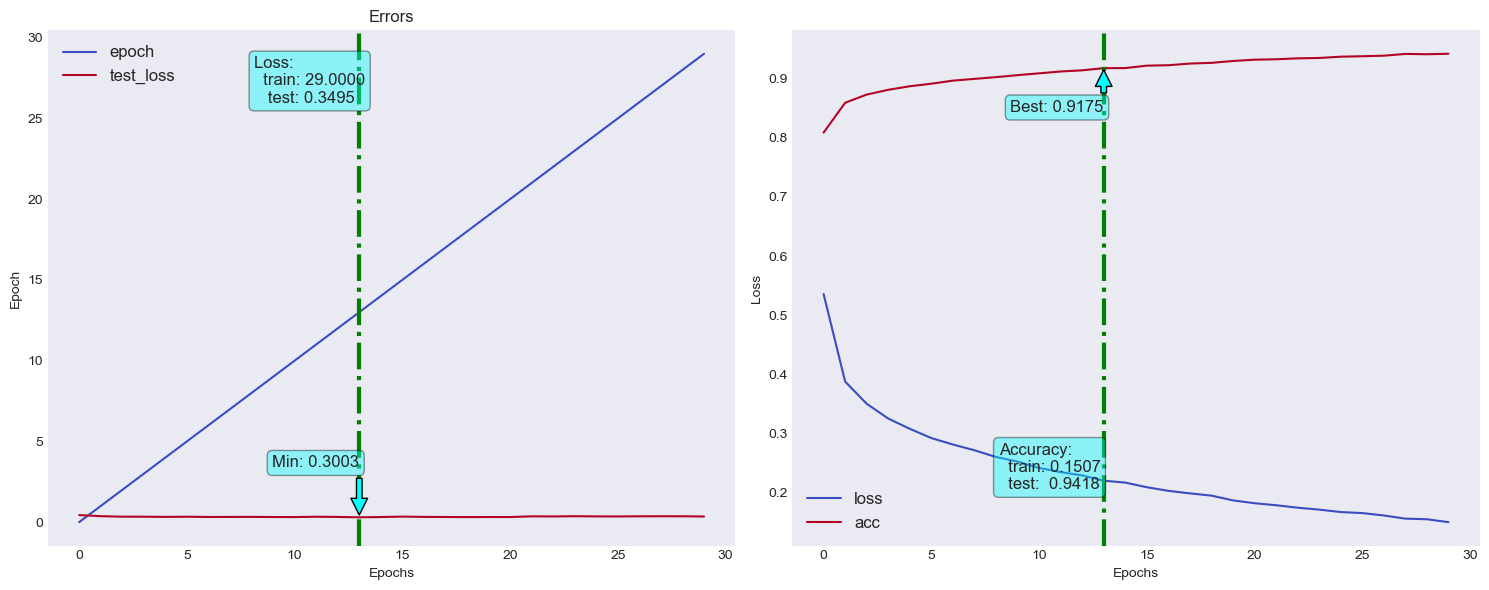

In [24]:
#fn_plot_tf_hist(loss_df)

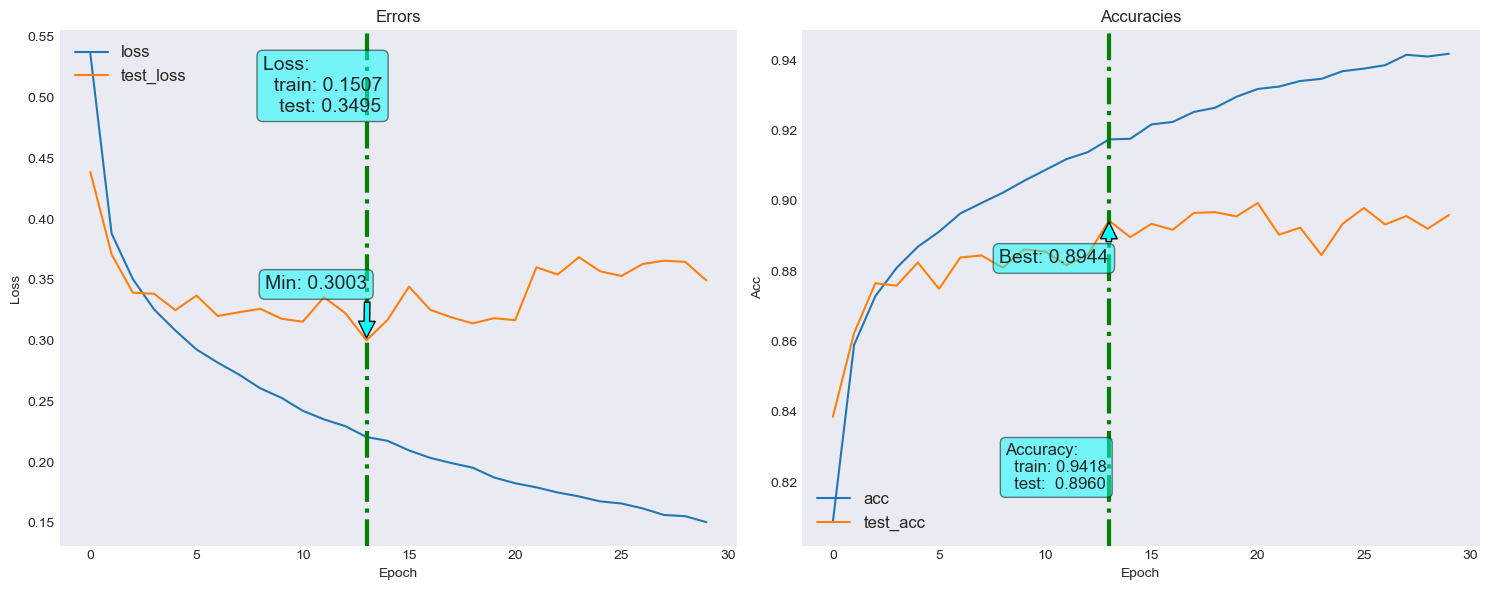

In [25]:
fn_plot_torch_hist(loss_df)

In [26]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):

    inputs, labels = data

    outputs = net(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [27]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      6000
           1       1.00      1.00      1.00      6000
           2       0.94      0.87      0.90      6000
           3       0.94      0.97      0.96      6000
           4       0.90      0.89      0.89      6000
           5       1.00      1.00      1.00      6000
           6       0.84      0.88      0.86      6000
           7       0.98      0.99      0.99      6000
           8       1.00      0.99      1.00      6000
           9       0.99      0.98      0.99      6000

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.95      0.95      0.95     60000



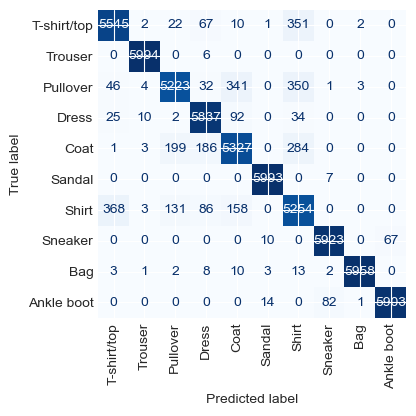

In [28]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

## Performance on test data

In [29]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):

    inputs, labels = data

    outputs = net(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [30]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.98      0.99      0.98      1000
           2       0.88      0.78      0.83      1000
           3       0.88      0.92      0.90      1000
           4       0.83      0.84      0.83      1000
           5       0.97      0.95      0.96      1000
           6       0.72      0.74      0.73      1000
           7       0.95      0.95      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



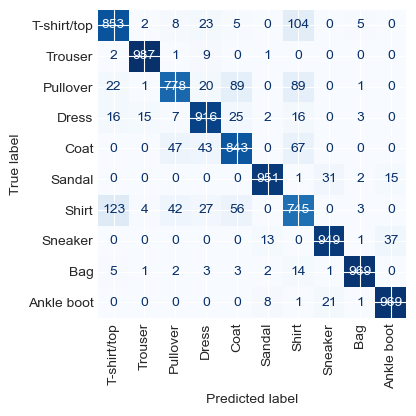

In [31]:
cmt  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmt,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();